## Visualise school traffic

In [89]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'LCA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]

school_paths = pd.read_parquet(join(resultsdir, "transport/path and flux data/LCA_schools_pathdata_time_m_60.parquet"))

loading config file from ../../...
Number of nodes: 8,275
Number of edges: 9,263


In [90]:
from shapely.geometry import MultiLineString

def get_multilinestring(path, edge_geoms):
    linestrings = [edge_geoms.loc[edge].geometry for edge in path]
    return MultiLineString(linestrings)


edge_geoms = roads[['edge_id', 'geometry']].set_index('edge_id')
school_paths['geometry'] = school_paths['edge_path'].apply(lambda path: get_multilinestring(path, edge_geoms))
school_paths = gpd.GeoDataFrame(school_paths, geometry='geometry').set_crs(caribbean_epsg)

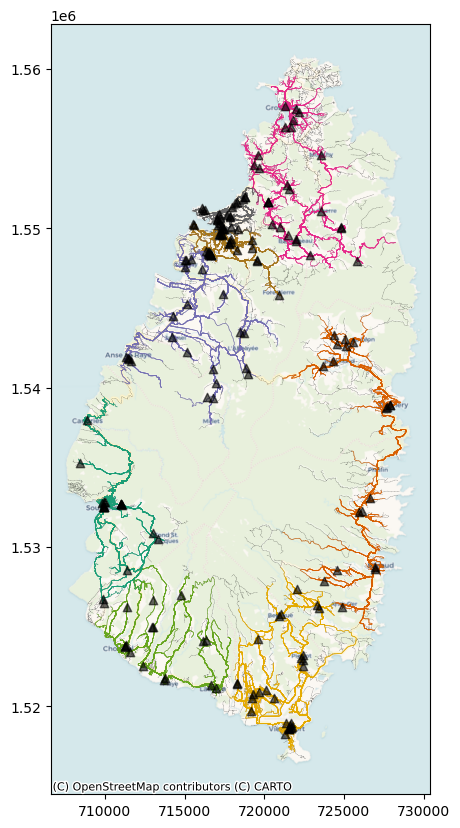

In [136]:
import contextily as cx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

roads.plot(color='black', linewidth=.2, alpha=.8, linestyle='--', ax=ax, zorder=1)
school_paths.plot('school_district', linewidth=.5, alpha=.8, categorical=True, ax=ax, cmap="Dark2", zorder=2)
schools.set_geometry(schools.centroid).plot(color='k', alpha=.6, ax=ax, marker="^", zorder=3)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=school_paths.crs, zoom=12)

fig.savefig(os.path.join(figdir, f"{COUNTRY}_school_routes.png"), **plot_kwargs)

In [137]:
school_paths.describe()

,time_m,flux
count,8991.000000,8991.000000
mean,2.746755,0.891137
std,2.590476,4.478663
min,0.004227,0.014628
25%,1.010312,0.026993
50%,1.901474,0.061653
75%,3.600869,0.225915
max,22.127911,90.505515


## Visualise school traffic disruption

In [146]:
import os
from os.path import join
import pandas as pd
import geopandas as gpd
from geospatial_utils import load_config
import transport_flow_and_disruption_functions as tfdf

plot_kwargs = {'dpi': 400, 'bbox_inches': 'tight'}

COUNTRY = 'LCA'
caribbean_epsg = 32620

CONFIG = load_config(os.path.join("..", "..", ".."))
datadir, resultsdir, figdir = CONFIG['paths']['data'], CONFIG['paths']['results'], CONFIG['paths']['figures']

# load roads, roads network, and schools
roads, road_net = tfdf.get_roads(join(datadir, 'infrastructure', 'transport'), COUNTRY, ['edge_id', 'length_m', 'time_m'])
roads = roads.to_crs(epsg=caribbean_epsg)
schools = gpd.read_file(join(datadir, 'infrastructure', 'social', 'education.gpkg'))
schools = schools[schools['iso_code'] == COUNTRY]

disruption_df = pd.read_parquet(join(resultsdir, "transport/disruption results/lca_schools_roads_edges_sector_damages_with_rerouting.parquet"))
disruption_df = disruption_df[['hazard', 'rcp', 'rp', 'trips_lost_mean', '%trips_lost_mean', 'time_m_delta_mean',
               '%time_m_delta_mean', '%time_m_delta_amax', 'rerouting_loss_person_time_m_mean', '%time_m_delta_total_mean']]
              

loading config file from ../../...
Number of nodes: 8,275
Number of edges: 9,263


array([[<Axes: title={'center': 'rp'}>,
        <Axes: title={'center': 'trips_lost_mean'}>,
        <Axes: title={'center': '%trips_lost_mean'}>],
       [<Axes: title={'center': 'time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_mean'}>,
        <Axes: title={'center': '%time_m_delta_amax'}>],
       [<Axes: title={'center': 'rerouting_loss_person_time_m_mean'}>,
        <Axes: title={'center': '%time_m_delta_total_mean'}>, <Axes: >]],
      dtype=object)

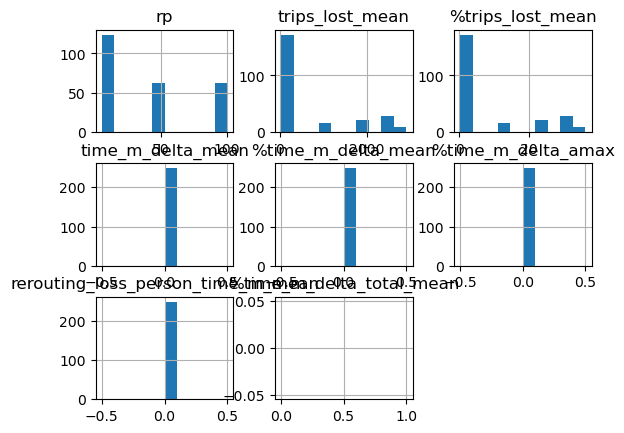

In [148]:
disruption_df.hist()